In [16]:
import numpy as np
import pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_prepare(x,y,data_config,warning=True):
    if y.ndim>1:
        assert 0,'y dim problem!'
    dataset = []
    labels = []
    selects = []
    for k,v in data_config.items():
        filt = y==k
        if v>np.sum(filt):
            if warning:
                v = np.sum(filt)
                assert v!=0,'No data is available!'
                print('WARNING! Requested data is not available, reduce the {} class. The number is reduced to {}!'.format(k,v))
            else:
                assert 0, 'Requested data is not available, reduce the {} class'.format(k)
        
        inds = np.argwhere(filt)[:,0]
        np.random.shuffle(inds)
        selceted = inds[:v]
        dataset.extend(x[selceted])
        labels.extend([k]*v)
        selects.extend(selceted)
    return np.delete(x, selects,axis=0),np.delete(y, selects,axis=0),np.array(dataset),np.array(labels)

# def describe_labels(y0):
#     y = y0+0
#     if y.ndim==2:
#         y = np.argmax(y,axis=1)
#     class_labels, nums = np.unique(y,return_counts=True)
#     n_calss = len(class_labels)
#     print('labels/numbers are:\n',*['{:5s}/{:6d}\n'.format(str(i),j) for i,j in zip(class_labels,nums)])
#     return n_calss

def describe_labels(y0,int_mapper=None,verbose=0):
    y = y0+0
    if y.ndim==2:
        y = np.argmax(y,axis=1)
    class_labels, nums = np.unique(y,return_counts=True)
    n_class = len(class_labels)
    tmp = '\t{:{width}s}/{:6d}\n'
    if verbose:
        print('labels/numbers are:')
        if int_mapper is None:
            ns = 6
    #         print('{:{width}s}/numbers are:'.format('labels',width=ns))
            print(*[tmp.format(str(i),j,width=ns) for i,j in zip(class_labels,nums)])
        else:
            ns = max([len(i) for i in list(int_mapper.values())])+3
    #         print('{:{width}s}/numbers are:'.format('labels',width=ns))
    #         print(tem.format(int_mapper[i],j,width=ns) for i,j in zip(class_labels,nums)])
            print(*[tmp.format(int_mapper[i],j,width=ns) for i,j in zip(class_labels,nums)])
    return n_class,class_labels, nums

def augment(aug,x):
    aug.fit(x)
    out = []
    for i in x:
        out.append(aug.random_transform(i))
    return np.array(out)

def balance_aug(x0,y0,aug=None,mixup=False,reshape=None):
#     assert y0.ndim>1,'Agumentor ndim problem!'
    
    if not reshape is None:
        shape0 = x0.shape
        x = x0.reshape(reshape)
    else:
        x = x0+0
    if y0.ndim==2:
        y = np.argmax(y0,axis=1)
        to_cat = True
    elif y0.ndim==1:
        y = y0+0
        to_cat = False
    else:
        assert 0,'Agumentor y ndim problem!'
        
    class_labels, nums = np.unique(y,return_counts=True)
    nmax = max(nums)
    for i,(lbl,n0) in enumerate(zip(class_labels,nums)):
        if nmax==n0:
            continue
        delta = nmax-n0
        x_sub = x[y==lbl]
        inds = np.arange(n0)
        nrep = (nmax//len(inds))+1
        inds = np.repeat(inds, nrep)
        np.random.shuffle(inds)
        inds = inds[:delta]
        x_sub = x_sub[inds]
        if not aug is None:
            x_sub = augment(aug,x_sub)
            
        if mixup:
            print('MIXUP is not supperted. IGNORED!')
            pass
            
        x = np.concatenate([x,x_sub],axis=0)
        y = np.concatenate([y,delta*[lbl]],axis=0)
        
    if not reshape is None:
        x = x.reshape([-1]+list(shape0)[1:])
    if to_cat:
        y = keras.utils.to_categorical(y)
    return x,y

class DataFeed:
    def __init__(self,x,y,aug = None):
        self.x = x
        self.y = y
        self.aug = aug
        self.nd,self.nx,self.ny,self.ch = x.shape
        self.banance()
        
    def banance(self):
        self.xb,self.yb = balance_aug(self.x,self.y,aug=self.aug)
        self.ndb = self.xb.shape[0]
    def __call__(self,num,reset=False):
        if reset:
            self.banance()
        inds = np.arange(self.ndb)
        np.random.shuffle(inds)
        inds = inds[:num]
        return self.xb[inds],self.yb[inds]

def rws_score(outliers,v,n_o=None):
    outliers = np.array(outliers)
    if n_o is None:
        n_o = int(np.sum(outliers))
    b_s = np.arange(n_o)+1
    o_ind = np.argsort(v)[::-1]
    o_ind = o_ind[:n_o]
    return 1.*np.sum(b_s*outliers[o_ind].reshape(-1))/np.sum(b_s)

INIT_LR = 1e-3

def lr_scheduler(epoch, lr):
    return lr * 0.985

import numpy as np

class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y
    
def mixup(x0,y0,alpha,beta,num_classes=None):
    x = x0+0
    y = y0+0
    
    tocat = False
    if y.ndim==1:
        y = keras.utils.to_categorical(y,num_classes=num_classes)
        tocat = True
        print('The labels are converted into categorical')

    class_labels, nums = np.unique(y,return_counts=True)
    # print(class_labels, nums)

    
    nums = np.sum(y,axis=0)

    nmax = max(nums)
    # for i,(lbl,n0) in enumerate(zip(class_labels,nums)):
    for i,n0 in enumerate(nums):

        if nmax==n0 or n0==0:
            continue
        delta = int(nmax-n0)
        
        x_sub = x[y[:,i].astype(bool)]
        y_sub = y[y[:,i].astype(bool)]

        inds = np.arange(n0)
        nrep = (nmax//len(inds))
        inds = np.repeat(inds, nrep)
        np.random.shuffle(inds)
        inds = inds[:delta].astype(int)

        x_sub = x_sub[inds]
        y_sub = y_sub[inds]

        b = np.random.beta(alpha,beta,delta)[:,None]

        inds = np.arange(x.shape[0])
        np.random.shuffle(inds)
        inds = inds[:delta]
        xt = x[inds]
        yt = y[inds]

        if x.ndim==2:
            x_sub = b[:,:]*x_sub+(1-b[:,:])*xt
        elif x.ndim==3:
            x_sub = b[:,:,None]*x_sub+(1-b[:,:,None])*xt
        elif x.ndim==4:
            x_sub = b[:,:,None,None]*x_sub+(1-b[:,:,None,None])*xt
        else:
            assert 0,'The shape is not as expected! {}-{}'.format(x.shape,x_sub.shape)
        
        y_sub = b*y_sub+(1-b)*yt

        x = np.concatenate([x,x_sub],axis=0)
        y = np.concatenate([y,y_sub],axis=0)
#     if tocat:
#         y = np.argmax(y,axis=1)
    return x,y


# callbacks = [
#     LearningRateScheduler(lr_scheduler, verbose=1)
# ]
def build_model(shape,n_class,n_latent = 64):
 
    inp = keras.Input(shape=shape, name="input")
    x = layers.Dense(128, activation="relu")(inp)
    latent = layers.Dense(n_latent, activation="relu")(x)
    dop = layers.Dropout(0.6)(latent)
    out = layers.Dense(n_class, activation="softmax")(dop)
    # out = layers.Dense(n_class, activation="sigmoid")(dop)


    clf = keras.Model(inputs=inp, outputs=out, name="Classifier")
    drt = keras.Model(inputs=inp, outputs=latent, name="DimensionalityReducer")

#     clf.summary()

    clf.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return clf,drt

def iforest_get_anomalies(z):
    isof = IsolationForest()
    isof.fit(z)
    scores_pred = isof.decision_function(z)
    scores_pred = scores_pred.max()-scores_pred
    return scores_pred

def load_npz(path,verbose=0):
    data = np.load(path)

    x = []
    y = []
    int_mapper = {}
    lbl_mapper = {}

    for i,key in enumerate(list(data)):
        dd = data[key]
        x.extend(dd)
        y.extend(dd.shape[0]*[i])
        int_mapper[i] = key
        lbl_mapper[key] = i
    x = np.array(x)
    y = np.array(y)

    if verbose:
        print(x.shape,y.shape)
        # describe_labels(y,int_mapper=None)
        describe_labels(y,int_mapper=int_mapper,verbose=verbose)

    return x,y,int_mapper,lbl_mapper

class Observetory:
    def __init__(self,plan,x,y):
        self.plan = plan
        self.x = x
        self.y = y
        self.x_obs = np.zeros( [0]+list(self.x.shape[1:]) )
        self.y_obs = np.zeros( [0]+list(self.y.shape[1:]) )
        self.num_obs = 0
        self.n_plan = len(self.plan)
#         self.new_obs()
    def new_obs(self,safemode=False,nightly=False):
        if self.num_obs==self.n_plan:
            if safemode:
#                 print('out of plan!')
                return self.x_obs,self.y_obs
            else:
                assert 0,'No more plan!' 
        data_config = self.plan[self.num_obs]
        self.x,self.y, x_obs, y_obs = data_prepare(self.x,self.y,data_config)
        self.x_obs = np.concatenate([self.x_obs,x_obs],axis=0)
        self.y_obs = np.concatenate([self.y_obs,y_obs],axis=0)
#         print(self.x_obs.shape, self.y_obs.shape, self.x.shape, self.y.shape)
        self.num_obs += 1
        if nightly:
            return x_obs,y_obs
        else:
            return self.x_obs,self.y_obs
    def delete(self,inds):
        self.x_obs = np.delete(self.x_obs,inds,axis=0)
        self.y_obs = np.delete(self.y_obs,inds,axis=0)

BOLD_BEGIN = '\033[1m'
BOLD_END   = '\033[0m' 

class AHunt:
    def __init__(self,x,y,clf,drt,interest,aug=None):
        self.x = x
        self.n_data = self.x.shape[0]
        self.y = y
        self.clf = clf
        self.n_class = clf.layers[-1].output_shape[-1]
        self.drt = drt
        self.interest = interest
        self.aug = aug
        self.asked_q = []

    def fit(self,
            x=None,
            y=None,
            batch_size=256,
            epochs=10,
            validation_split=0.1,
            verbose=0,
            reshape=None
           ):
        if x is None or y is None:
            x = self.x
            y = self.y
        
#         print(x.shape,y.shape)
        xx,yy = balance_aug(x,y,self.aug,reshape=reshape)
        yy = keras.utils.to_categorical(yy, num_classes=self.n_class)
        history = self.clf.fit(xx, yy,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_split=validation_split,
                               verbose=verbose)
        return history

    def ask_human(self,x,y,n_questions,minacc=0.0):
        out_obs = y==self.interest
        ano_inds = np.argwhere(out_obs)[:,0]
        z_clf = self.clf.predict(x)
        scr_ano = z_clf[:,self.interest]
        qlist = np.argsort(scr_ano)[::-1]
        inds_all = []
        inds_interest = []
        for q in qlist:
            mn = 10000
            for asked in self.asked_q:
                dist = np.sum( (x[q]-asked)**2 )
                mn = min(mn,dist)
            if mn>minacc:
                inds_all.append(q)
                if q in ano_inds:
                    inds_interest.append(q)
            if len(inds_all)==n_questions: break
        return inds_all,inds_interest
    
    def human_call1(self,x,y,n_questions,minacc=0.0):
#         ano_inds = np.argwhere(out2)[:,0]

        inds_all,inds_interest = self.ask_human(x,y,n_questions,minacc=minacc)
#         [-n_questions:]
#         inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds_interest)
        self.asked_q.extend(x[inds_interest])
        self.x = np.concatenate([x[inds_interest],self.x],axis=0)
        self.n_data = self.x.shape[0]
        self.y = np.concatenate([y[inds_interest],self.y],axis=0)
        return true_guess

    def human_call2(self,x,y,n_questions,minacc=0.0):
#         ano_inds = np.argwhere(out2)[:,0]
#         scr_ano = self.predict(x)
#         qinds = np.argsort(scr_ano)[-n_questions:]
#         inds = np.intersect1d(qinds,ano_inds)
        inds_all,inds_interest = self.ask_human(x,y,n_questions,minacc=minacc)
        true_guess = len(inds_interest)
        self.asked_q.extend(x[inds_all])
        self.x = np.concatenate([x[inds_all],self.x],axis=0)
        self.n_data = self.x.shape[0]
        self.y = np.concatenate([y[inds_all],self.y],axis=0)
        return true_guess

    def predict(self,x):
        z_clf = self.clf.predict(x)
        return z_clf[:,self.interest]
    
    def class_predict(self,x):
        return self.clf.predict(x)
    
    def to_latent(self,x):
        z_mu = self.drt.predict(x)
        return z_mu
    
def stds_model(clf):
    ws = []
    bs = []
    for layer in clf.layers:
        if isinstance(layer,layers.Dense):
            ws.append(layer.weights[0].numpy().std())
            bs.append(layer.weights[1].numpy().std())
    return np.array(ws),np.array(bs)
# stds_model(clf)

from sklearn.metrics import recall_score,precision_score,classification_report,confusion_matrix,matthews_corrcoef

def compare(path,
            noise,
            outlier_ind,
            pre_data_config,
            obs_plan,
            n_questions,
            aug = None,
            n_night = None,
            nightly = False,
            epochs = 5):
    
    print(BOLD_BEGIN+'Loaded data configuration:'+BOLD_END)
    x,y,int_mapper,lbl_mapper = load_npz(path,verbose=0)
    x = x/x.max()
    n_tot,lx,ly = x.shape
    x = x.reshape(n_tot,lx*ly)
    if noise!=0:
        x += np.random.normal(0,noise,x.shape)
    n_class,class_labels, nums = describe_labels(y,verbose=0)
#     print(n_class)
    print(BOLD_BEGIN+' ******** previous dataset ******** '+BOLD_END)

    x, y, x_pre, y_pre = data_prepare(x,y,pre_data_config)
    describe_labels(y_pre,verbose=0)
    # x_obs = x_obs_orig.reshape(x_obs_orig.shape[0],-1)
    # y_obs1 = y_obs_orig+0

    print(BOLD_BEGIN+' ******** Observation begins ******** '+BOLD_END)
    obs = Observetory(obs_plan,x,y)

    rws1,rws2,rws3,rws4 = [],[],[],[]
    tg1,tg2,tg3,tg4 = [],[],[],[]
    rc1,rc2,rc3,rc4 = [],[],[],[]
    pr1,pr2,pr3,pr4 = [],[],[],[]
    mcc1,mcc2,mcc3,mcc4 = [],[],[],[]
#     print(n_class)
    clf,drt = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
    ahunt = AHunt(x_pre, y_pre,clf,drt,interest=outlier_ind,aug=aug)
    ahunt.fit(reshape=(-1,lx,ly,1))

    clf0,drt0 = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
    ahunt0 = AHunt(x_pre, y_pre,clf0,drt0,interest=outlier_ind,aug=aug)
    ahunt0.fit(reshape=(-1,lx,ly,1))

    model_par = []
    model_par.append(stds_model(clf))
    
    if n_night is None: n_night = obs.n_plan
    
    for _ in range(n_night):
        x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
    #     describe_labels(y_obs,verbose=1)

        out_obs = y_obs==outlier_ind
        y_true = out_obs.astype(int)
        n_anomaly = np.sum(out_obs)
        ano_inds = np.argwhere(out_obs)[:,0]

        # Method 1
        
        scr_ano = iforest_get_anomalies(x_obs)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws1.append(rws)
        rc1.append(rc)
        pr1.append(pr)
        mcc1.append(mcc)
#         assert 0

        qinds = np.argsort(scr_ano)[-n_questions:]
        inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds)
        tg1.append(true_guess)
        
        # Method 2
        
        z_mu = ahunt0.to_latent(x_obs)
        scr_ano = iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws2.append(rws)
        rc2.append(rc)
        pr2.append(pr)
        mcc2.append(mcc)
        
        qinds = np.argsort(scr_ano)[-n_questions:]
        inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds)
        tg2.append(true_guess)

        # Method 3
        
        z_mu = ahunt.to_latent(x_obs)
        scr_ano = iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws3.append(rws)
        rc3.append(rc)
        pr3.append(pr)
        mcc3.append(mcc)

        qinds = np.argsort(scr_ano)[-n_questions:]
        inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds)
        tg3.append(true_guess)
        
        # Method 4
#         true_guess = ano_hunt.human_call1(x_obs,y_obs,n_questions)
        true_guess = ahunt.human_call2(x_obs,y_obs,n_questions)
        tg4.append(true_guess)

        ahunt.fit(reshape=(-1,lx,ly,1))
        model_par.append(stds_model(clf))
        scr_ano = ahunt.predict(x_obs)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws4.append(rws)
        rc4.append(rc)
        pr4.append(pr)
        mcc4.append(mcc)
        
#         print('this',y_true.sum(),y_pred.sum())
#         print(confusion_matrix(y_true, y_pred))
#         print(classification_report(y_true,y_pred))
#     assert 0
    rwss = [rws1,rws2,rws3,rws4]
    tgs = [tg1,tg2,tg3,tg4]
    rcs = [rc1,rc2,rc3,rc4]
    prs = [pr1,pr2,pr3,pr4]
    mccs = [mcc1,mcc2,mcc3,mcc4]
    
    return rwss,tgs,rcs,prs,mccs,model_par

def analyze(xx,cl=2.5):
    m = np.mean(xx,axis=0)
    l = np.percentile(xx,cl,axis=0)
    u = np.percentile(xx,100-cl,axis=0)
    return m,l,u

def planmaker(path,nmin_pre=None,outlier_ind=None):

    data = np.load(path)
    shapes = []
    keys = []
    for key in list(data):
        shapes.append(data[key].shape)
        keys.append(key)
    shapes = np.array(shapes)
    inds_sorted = np.argsort(shapes[:,0])
    outlier_indp = inds_sorted[0]
    
    if outlier_ind is None or outlier_indp==outlier_ind:
        outlier_ind = outlier_indp
        nmin = shapes[inds_sorted[0]][0]//25
        nmaj = shapes[inds_sorted[1]][0]//25
        nmin = min(nmin,nmaj//10)
    else:
        nmin = shapes[inds_sorted[0]][0]//25
        nmaj = shapes[inds_sorted[1]][0]//25
        nmin = min(nmin,nmaj//10)    
    print('outlier is ',keys[outlier_ind])
    if nmin_pre is None:
        nmin_pre = 3*nmin
    pre_data_config = {i:(i==outlier_ind)*nmin_pre+3*(i!=outlier_ind)*nmaj for i in range(len(list(data)))}
    obs_plan = 20*[{i:(i==outlier_ind)*nmin+(i!=outlier_ind)*nmaj for i in range(len(list(data)))}]
    return nmin,outlier_ind,pre_data_config,obs_plan

def run_for(fname,
            epochs = 5,
            noise = 0.0,
            n_night = 30,
            nightly=False,
            ntry = 5,
            n_questions = None,
            outlier_ind = None,
            pre_data_config = None,
            obs_plan = None,
            aug = None,
            nmin_pre=None,
            prefix = ''):
    # n_questions = 7
    # pre_data_config = {0:100,1:1}
    # obs_plan = 10*[{0:100,1:10}]
    # outlier_ind = 1
    path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)

    nmin,outlier_ind0,pre_data_config0,obs_plan0 = planmaker(path,nmin_pre=nmin_pre,outlier_ind=outlier_ind)
    n_questions0 = int(0.7*nmin)
    
    if n_questions is None: n_questions=n_questions0
    if outlier_ind is None: outlier_ind=outlier_ind0
    if pre_data_config is None: pre_data_config=pre_data_config0
    if obs_plan is None: obs_plan=obs_plan0
    print(pre_data_config)
    print(obs_plan[0])

    rws1s,rws2s,rws3s,rws4s = [],[],[],[]
    tg1s,tg2s,tg3s,tg4s  = [],[],[],[]
    rc1s,rc2s,rc3s,rc4s = [],[],[],[]
    pr1s,pr2s,pr3s,pr4s = [],[],[],[]
    mcc1s,mcc2s,mcc3s,mcc4s = [],[],[],[]

    model_pars = []
    for _ in range(ntry):
        res = compare(path = path,
                      noise = noise,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      n_questions = n_questions,
                      aug = None,
                      n_night=n_night,
                      nightly=nightly,
                      epochs = epochs
                     )

        rwss,tgs,rcs,prs,mccs,model_par = res

        rws1,rws2,rws3,rws4 = rwss
        tg1,tg2,tg3,tg4 = tgs
        rc1,rc2,rc3,rc4 = rcs
        pr1,pr2,pr3,pr4 = prs
        mcc1,mcc2,mcc3,mcc4 = mccs

        rws1s.append(rws1)
        rws2s.append(rws2)
        rws3s.append(rws3)
        rws4s.append(rws4)
        tg1s.append(tg1)
        tg2s.append(tg2)
        tg3s.append(tg3)
        tg4s.append(tg4)
        rc1s.append(rc1)
        rc2s.append(rc2)
        rc3s.append(rc3)
        rc4s.append(rc4)
        pr1s.append(pr1)
        pr2s.append(pr2)
        pr3s.append(pr3)
        pr4s.append(pr4)
        mcc1s.append(mcc1)
        mcc2s.append(mcc2)
        mcc3s.append(mcc3)
        mcc4s.append(mcc4)
        model_pars.append(model_par)

    np.savez('{}{}_res'.format(prefix,fname),
            rws1s = np.array(rws1s),
            rws2s = np.array(rws2s),
            rws3s = np.array(rws3s),
            rws4s = np.array(rws4s),

            tg1s = np.array(tg1s),
            tg2s = np.array(tg2s),
            tg3s = np.array(tg3s),
            tg4s = np.array(tg4s),

            rc1s = np.array(rc1s),
            rc2s = np.array(rc2s),
            rc3s = np.array(rc3s),
            rc4s = np.array(rc4s),

            pr1s = np.array(pr1s),
            pr2s = np.array(pr2s),
            pr3s = np.array(pr3s),
            pr4s = np.array(pr4s),

            mcc1s = np.array(mcc1s),
            mcc2s = np.array(mcc2s),
            mcc3s = np.array(mcc3s),
            mcc4s = np.array(mcc4s),
            model_pars = np.array(model_pars)
           )

    return n_questions
    
def plot_for(fname,n_questions,prefix=''):
    alpha = 0.2
    data = np.load('{}{}_res.npz'.format(prefix,fname))
#     for i in list(data):
#         print(i)
#         exec("{}=np.array(data['{}'])".format(i,i),locals=locals)

    rws1s = data['rws1s']
    rws2s = data['rws2s']
    rws3s = data['rws3s']
    rws4s = data['rws4s']

    tg1s =  data['tg1s']
    tg2s =  data['tg2s']
    tg3s =  data['tg3s']
    tg4s =  data['tg4s']

    rc1s =  data['rc1s']
    rc2s =  data['rc2s']
    rc3s =  data['rc3s']
    rc4s =  data['rc4s']

    pr1s =  data['pr1s']
    pr2s =  data['pr2s']
    pr3s =  data['pr3s']
    pr4s =  data['pr4s']

    mcc1s = data['mcc1s']
    mcc2s = data['mcc2s']
    mcc3s = data['mcc3s']
    mcc4s = data['mcc4s']
    model_pars = data['model_pars']
        
             
#     fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

#     clrs = ['r','b','g']
#     for i in range(3):
#         clr = clrs[i]

#         m,l,u = analyze(model_pars[:,:,0,i])
#         ax1.plot(m,clr,label='layer='+str(i))
#         ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

#         m,l,u = analyze(model_pars[:,:,1,i])
#         ax2.plot(m,clr,label='layer='+str(i))
#         ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

#     ax1.set_xlabel('night',fontsize=15)
#     ax2.set_xlabel('night',fontsize=15)
#     ax1.set_ylabel('mean weights',fontsize=15)
#     ax2.set_ylabel('mean bias',fontsize=15)
#     ax1.legend(fontsize=13)

#     ax1.set_xlim(0,m.shape[0]-1)
#     # ax1.set_ylim(0,1)
#     ax2.set_xlim(0,m.shape[0]-1)
#     # ax2.set_ylim(0,5.5)

#     plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
#     plt.savefig('{}layers_{}.jpg'.format(prefix,fname),dpi=150)
#     plt.close()

             
    fig,axs = plt.subplots(2,2,figsize=(14,10))

    ax = axs[0,0]

    m,l,u = analyze(rws1s)
    clr = 'k'
    ax.plot(m,clr,label='iforest_raw')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rws2s)
    clr = 'r'
    ax.plot(m,clr,label='iforest_latent-static')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rws3s)
    clr = 'g'
    ax.plot(m,clr,label='iforest_latent-learning')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rws4s)
    clr = 'b'
    ax.plot(m,clr,label='AHunt')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('RWS',fontsize=15)

    ax.legend(fontsize=13)
    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,1)

    ax = axs[0,1]

    m,l,u = analyze(100*tg1s/n_questions)
    clr = 'k'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(100*tg2s/n_questions)
    clr = 'r'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(100*tg3s/n_questions)
    clr = 'g'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(100*tg4s/n_questions)
    clr = 'b'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('True candidates (%)',fontsize=15)

    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,102)


    ax = axs[1,0]

    m,l,u = analyze(rc1s)
    clr = 'k'
    ax.plot(m,clr,label='iforest_raw')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rc2s)
    clr = 'r'
    ax.plot(m,clr,label='iforest_latent-static')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rc3s)
    clr = 'g'
    ax.plot(m,clr,label='iforest_latent-learning')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rc4s)
    clr = 'b'
    ax.plot(m,clr,label='AHunt')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('recall',fontsize=15)

#     ax.legend(fontsize=13)
    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,1)


    ax = axs[1,1]

    # m,l,u = analyze(pr1s)
    # clr = 'y'
    # ax.plot(m,clr,label='iforest_raw')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # m,l,u = analyze(pr2s)
    # clr = 'r'
    # ax.plot(m,clr,label='iforest_latent-static')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # m,l,u = analyze(pr3s)
    # clr = 'g'
    # ax.plot(m,clr,label='iforest_latent-learning')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # m,l,u = analyze(pr4s)
    # clr = 'b'
    # ax.plot(m,clr,label='AnoHunt')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # ax.set_xlabel('night',fontsize=15)
    # ax.set_ylabel('precision',fontsize=15)

    m,l,u = analyze(mcc1s)
    clr = 'k'
    ax.plot(m,clr,label='iforest_raw')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(mcc2s)
    clr = 'r'
    ax.plot(m,clr,label='iforest_latent-static')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(mcc3s)
    clr = 'g'
    ax.plot(m,clr,label='iforest_latent-learning')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(mcc4s)
    clr = 'b'
    ax.plot(m,clr,label='AHunt')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('MCC',fontsize=15)

#     ax.legend(fontsize=13)
    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,1)


    plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
    plt.savefig('{}result_{}.jpg'.format(prefix,fname),dpi=150)

In [9]:
aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.03,
    height_shift_range=0.03,
#     brightness_range=0.01,
#        shear_range=0.0,
    zoom_range=0.03,
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode="nearest")

In [10]:
path = '/home/vafaeisa/scratch/datasets/prepared/sarscov2-ctscan_64_64.npz'
load_npz(path,verbose=1);

(2481, 64, 64) (2481,)
labels/numbers are:
	COVID       /  1252
 	non_COVID   /  1229



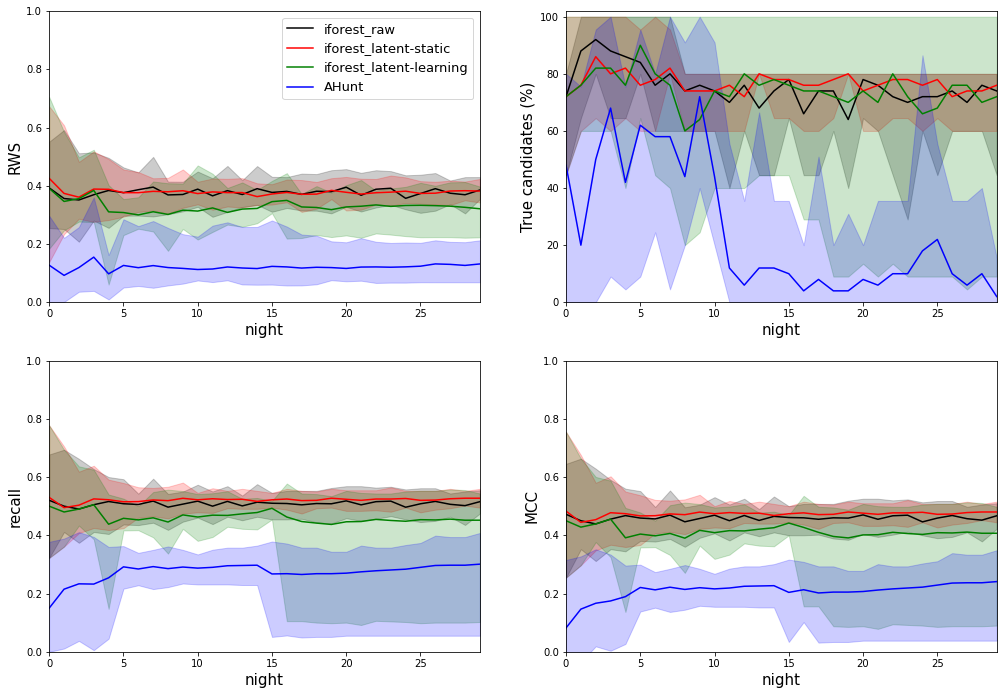

In [17]:
fname = 'sarscov2-ctscan_64_64'
epochs = 5
noise = 0.0
n_questions = 5
pre_data_config = {0:0,1:100}
obs_plan = 11*[{0:10,1:100}]
outlier_ind = 0

# n_questions = run_for(fname=fname,
#                       epochs = epochs,
#                       noise = noise,
#                       n_night = 30,
#                       nightly=False,
#                       ntry = 10,
#                       n_questions = n_questions,
#                       outlier_ind = outlier_ind,
#                       pre_data_config = pre_data_config,
#                       obs_plan = obs_plan,
#                       aug = aug,
#                       nmin_pre=None,
#                       prefix='figs/all-')
plot_for(fname=fname,n_questions=n_questions,prefix='figs/all-')

outlier is  COVID
{0: 100, 1: 0}
{0: 100, 1: 10}
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuratio

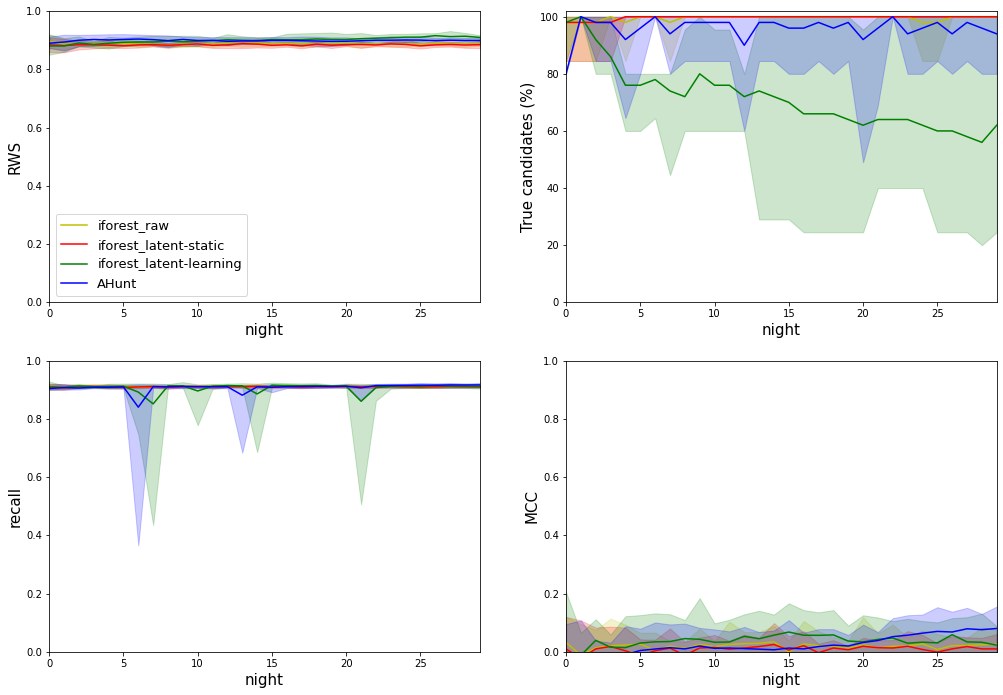

In [13]:
fname = 'sarscov2-ctscan_64_64'
epochs = 5
noise = 0.0
n_questions = 5
pre_data_config = {0:100,1:0}
obs_plan = 11*[{0:100,1:10}]
outlier_ind = 0

n_questions = run_for(fname=fname,
                      epochs = epochs,
                      noise = noise,
                      n_night = 30,
                      nightly=False,
                      ntry = 10,
                      n_questions = n_questions,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      aug = aug,
                      nmin_pre=None,
                      prefix='figs/all-')
plot_for(fname=fname,n_questions=n_questions,prefix='figs/all-')

In [14]:
path = '/home/vafaeisa/scratch/datasets/prepared/pneumoniamnist.npz'
load_npz(path,verbose=1);

(5856, 28, 28) (5856,)
labels/numbers are:
	class0   /  1583
 	class1   /  4273



In [ ]:
fname = 'pneumoniamnist'
epochs = 5
noise = 0.0
n_questions = 5
pre_data_config = {0:1,1:100}
obs_plan = 11*[{0:10,1:100}]
outlier_ind = 0

n_questions = run_for(fname=fname,
                      epochs = epochs,
                      noise = noise,
                      n_night = 30,
                      nightly=False,
                      ntry = 10,
                      n_questions = n_questions,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      aug = aug,
                      nmin_pre=None,
                      prefix='figs/all-')
plot_for(fname=fname,n_questions=n_questions,prefix='figs/all-')